# Import essential libraries

In [1]:
!pip install pyLDAvis
import nltk
nltk.download('wordnet')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import pyLDAvis.sklearn

     |████████████████████████████████| 1.6MB 5.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=9f3ac8368ab12b86992bfae43d4c2ef12eba878771586ceb64c94f70e81483c7
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
def lemma_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [3]:
main_df = pd.read_csv('NYT2000_1.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
temp_df = pd.read_csv('NYT2000_2.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
main_df = pd.concat([main_df,temp_df], ignore_index=True)

In [4]:
# Remove NaN values, lowercase contents of Body column, filters for bush and gore and resets the index
print(main_df.shape)
main_df.dropna(subset=['Body'], inplace=True)
print(main_df.shape)

main_df['Body'] = main_df['Body'].str.lower()
main_df = main_df[main_df['Body'].str.contains('gore|bush')]
main_df = main_df.reset_index(drop=True)

(50130, 4)
(49471, 4)


In [5]:
# Create a single date column from day, month and year columns
main_df['Date'] = pd.to_datetime(
    main_df['Publication Year'] * 10000 + main_df['Publication Month'] * 100 + main_df['Publication Day Of Month'],
    format='%Y%m%d')
main_df.drop(['Publication Year', 'Publication Month', 'Publication Day Of Month'], axis=1, inplace=True)
print(main_df.shape)

(4706, 2)


In [6]:
# Remove unnecessary symbols, numbers, words less than 3 characters and apply lemmatizer
main_df['Body'].replace([r'[,\.!?]', r'\d+', r'\b(\w{1,2})\b'], '', inplace=True, regex=True)
main_df['Body'].apply(lemma_text)
main_df['Body'] = main_df['Body'].str.replace('said', '', regex=False)
print(main_df['Body'].head(10))

0    just before the july  recess  senate committee...
1    george  bush -- pittsburgh and east brunswick ...
2    drivers have been paying almost twice  much fo...
3    for farmers the months leading  harvest time a...
4    international -  and vietnam reach broad trade...
5    dna test fails  exonerate prisoner given stay ...
6    former senator bill bradley made  official tod...
7    from his opening salutation ''   member  the n...
8    the democratic national committee' new televis...
9    several homeowners cell phones  hand tend thei...
Name: Body, dtype: object


In [7]:
# Generate doc-term matrix
cv = CountVectorizer(stop_words='english', max_df=3500)
ft_cv = cv.fit_transform(main_df['Body'])
vocabulary = cv.get_feature_names()

doc_term_matrix = pd.DataFrame(ft_cv.toarray(), columns=vocabulary)
print(doc_term_matrix.shape)

(4706, 63104)


In [8]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.decomposition._online_lda_fast import _dirichlet_expectation_2d
class PTWGuidedLatentDirichletAllocation(LatentDirichletAllocation):

    def __init__(self, n_components=10, *, doc_topic_prior=None,
                 topic_word_prior=None, learning_method='batch',
                 learning_decay=.7, learning_offset=10., max_iter=10,
                 batch_size=128, evaluate_every=-1, total_samples=1e6,
                 perp_tol=1e-1, mean_change_tol=1e-3, max_doc_update_iter=100,
                 n_jobs=None, verbose=0, random_state=None, 
                 ptws=None):
        super(PTWGuidedLatentDirichletAllocation, self).__init__(n_components, doc_topic_prior, topic_word_prior, learning_method, learning_decay, learning_offset, max_iter, batch_size, evaluate_every, total_samples, perp_tol, mean_change_tol, max_doc_update_iter, n_jobs, verbose, random_state)
        self.ptws = ptws

    def _init_latent_vars(self, n_features):
        """Initialize latent variables."""

        self.random_state_ = check_random_state(self.random_state)
        self.n_batch_iter_ = 1
        self.n_iter_ = 0

        if self.doc_topic_prior is None:
            self.doc_topic_prior_ = 1. / self.n_components
        else:
            self.doc_topic_prior_ = self.doc_topic_prior

        if self.topic_word_prior is None:
            self.topic_word_prior_ = 1. / self.n_components
        else:
            self.topic_word_prior_ = self.topic_word_prior

        init_gamma = 100.
        init_var = 1. / init_gamma
        # In the literature, this is called `lambda`
        self.components_ = self.random_state_.gamma(
            init_gamma, init_var, (self.n_components, n_features))

        # Transform topic values in matrix for prior topic words
        if self.ptws is not None:
            for ptw in self.ptws:
                word_index = ptw[0]
                word_topic_values = ptw[1]
                self.components_[:, word_index] *= word_topic_values

        # In the literature, this is `exp(E[log(beta)])`
        self.exp_dirichlet_component_ = np.exp(
            _dirichlet_expectation_2d(self.components_))

In [9]:
# Fit LDA model to doc-term matrix
k = 15

lda = PTWGuidedLatentDirichletAllocation(n_components=15)

lda.fit(ft_cv)

print('log likelihood score, 15 topics: ' + str(lda.score(ft_cv)))
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda, ft_cv, cv)
pyLDAvis.display(p)

log likelihood score, 15 topics: -17613486.590916708


(4706, 16)
(194, 15)
                  0         1         2   ...        12        13        14
Date                                      ...                              
2000-05-01  0.601523  1.017849  0.205523  ...  1.074771  0.499875  2.858847
2000-05-02  0.122385  0.526397  0.434950  ...  0.661527  0.703049  2.943343
2000-05-03  0.535011  1.888319  0.260975  ...  1.531796  1.092281  3.246362
2000-05-04  0.892448  0.883468  0.186870  ...  1.356714  1.854559  3.846577
2000-05-05  0.388987  0.579161  0.361749  ...  1.543643  0.142483  4.781733
2000-05-06  0.512290  0.342218  0.762607  ...  0.500307  0.036837  3.465155
2000-05-07  2.197526  3.190135  2.489157  ...  4.050968  0.080708  3.184975
2000-05-08  0.305557  0.106077  1.113294  ...  0.714076  0.818949  2.163250
2000-05-09  0.976140  0.446722  0.171431  ...  1.842727  0.012872  3.415939
2000-05-10  0.107018  1.756877  0.263236  ...  1.559125  0.100092  4.086087

[10 rows x 15 columns]


<Figure size 1152x720 with 0 Axes>

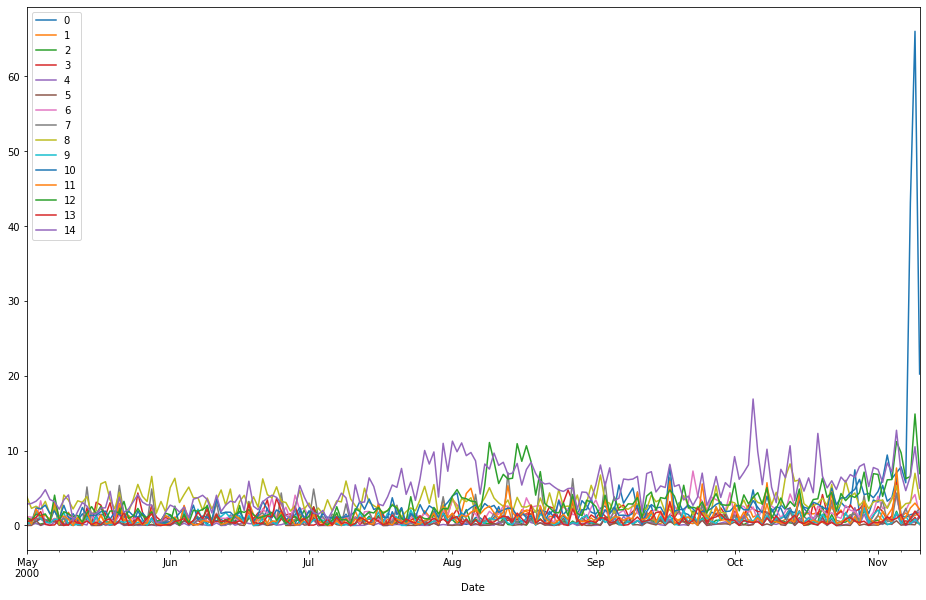

In [10]:
# Generate doc-topic matrix
lda_out = lda.transform(ft_cv)
doc_topic_matrix = pd.DataFrame(lda_out)
doc_topic_matrix['Date'] = main_df['Date']
print(doc_topic_matrix.shape)

aggregator = {i: 'sum' for i in range(k)}
coverage_curve = doc_topic_matrix.groupby(['Date']).agg(aggregator)
print(coverage_curve.shape)
print(coverage_curve.head(10))

plt.rcParams['figure.figsize'] = [16, 10]
plt.figure()
coverage_curve.plot()
plt.show()

In [11]:
#Read the IEM data and Normalize one of the stocks
iem_data = pd.read_excel('IEM2000.xlsx')
iem_data.drop(['Units', '$Volume', 'LowPrice','HighPrice','AvgPrice'], axis=1, inplace=True)

dem_data = iem_data[iem_data['Contract'].str.contains('Dem')]
rep_data = iem_data[iem_data['Contract'].str.contains('Rep')]

dem_data.set_index('Date', inplace=True)
rep_data.set_index('Date', inplace=True)

dem_data['NormLastPrice'] = dem_data['LastPrice'] / (dem_data['LastPrice'] + rep_data['LastPrice'])
dem_data.drop(['LastPrice', 'Contract'], axis=1, inplace=True)

print(dem_data.head())

            NormLastPrice
Date                     
2000-05-01       0.523810
2000-05-02       0.504970
2000-05-03       0.509491
2000-05-04       0.511466
2000-05-05       0.520875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
combined_data = pd.concat([dem_data, coverage_curve], axis=1, join='inner')
print(combined_data.head())
print(combined_data.tail())
print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_data.index))


            NormLastPrice         0         1  ...        12        13        14
Date                                           ...                              
2000-05-01       0.523810  0.601523  1.017849  ...  1.074771  0.499875  2.858847
2000-05-02       0.504970  0.122385  0.526397  ...  0.661527  0.703049  2.943343
2000-05-03       0.509491  0.535011  1.888319  ...  1.531796  1.092281  3.246362
2000-05-04       0.511466  0.892448  0.883468  ...  1.356714  1.854559  3.846577
2000-05-05       0.520875  0.388987  0.579161  ...  1.543643  0.142483  4.781733

[5 rows x 16 columns]
            NormLastPrice         0         1  ...         12        13         14
Date                                           ...                                
2000-11-06       0.290419  1.301417  1.169285  ...   9.706334  1.470584   6.931131
2000-11-07       0.166667  1.090571  1.674791  ...   6.265527  0.082860   4.653221
2000-11-08       0.922000  1.438178  1.146305  ...   6.530715  0.916533   6.58

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_results1 = grangercausalitytests(combined_data[['NormLastPrice',2]],5,addconst=True, verbose=False)
granger_results2 = grangercausalitytests(combined_data[['NormLastPrice',7]],5)
granger_results3 = grangercausalitytests(combined_data[['NormLastPrice',10]],5)
granger_results4 = grangercausalitytests(combined_data[['NormLastPrice',11]],5)
granger_results5 = grangercausalitytests(combined_data[['NormLastPrice',12]],5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4864  , p=0.4864  , df_denom=190, df_num=1
ssr based chi2 test:   chi2=0.4941  , p=0.4821  , df=1
likelihood ratio test: chi2=0.4935  , p=0.4824  , df=1
parameter F test:         F=0.4864  , p=0.4864  , df_denom=190, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3313  , p=0.7184  , df_denom=187, df_num=2
ssr based chi2 test:   chi2=0.6802  , p=0.7117  , df=2
likelihood ratio test: chi2=0.6790  , p=0.7121  , df=2
parameter F test:         F=0.3313  , p=0.7184  , df_denom=187, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8032  , p=0.4936  , df_denom=184, df_num=3
ssr based chi2 test:   chi2=2.5013  , p=0.4751  , df=3
likelihood ratio test: chi2=2.4850  , p=0.4780  , df=3
parameter F test:         F=0.8032  , p=0.4936  , df_denom=184, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7706  , p=0.5456  

In [32]:
  optimal_lag = -1
  F_test = -1.0
  for key in granger_results1.keys():
      _F_test_ = granger_results1[key][0]['params_ftest'][0]
      print(_F_test_)
      if _F_test_ > F_test:
          F_test = _F_test_
          optimal_lag = key

1.1312676297324402
0.8415052720883232
1.611313298390255
1.1702133423632537
0.9671056015599053


In [31]:
optimal_lag

3